# Data Science Final Project: Bag-of-Words Representation
## Group Members: Jiacheng Shi, Boyuan Sun, Xiangru

## Library Used

In [41]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
import string
import ast
import re
import warnings
from meter import score
import seaborn as sns
sns.set_style('white')
sns.set_context('paper', font_scale=1.5)
warnings.filterwarnings('ignore')

## Data Preprocessing

In [2]:
# read in data
imdb_movie = pd.read_csv('data/imdb_multilabel.csv')

# drop movies with unknown plot
imdb_movie['plot'] = imdb_movie['plot'].apply(lambda sentence: 'drop' if (('plot ' in sentence.lower()) 
                                              and ('unknown' in sentence.lower()))
                                              or (len(sentence.split()) < 100) 
                                              else sentence.lower())
imdb_movie = imdb_movie[imdb_movie['plot'] != 'drop']

# single-label encoding
genre_dict = dict(zip(imdb_movie.genre.unique(), range(20)))
genre_dict['sci-fi'] = 8
imdb_movie['genre_code'] = imdb_movie.genre.replace(genre_dict).values

# multi-label encoded as an array
def multi_label_encoder(all_genre_list):
    """ This function takes a list of genre with a dictionary that keeps track of the index of the genre
    INPUTS
    ------
    all_genre_list: list of genres
    genre_dict: dictionary of indexs
    
    OUTPUTS
    -------
    np array in {0, 1}
    """
    encode = np.zeros(20)
    all_genre_list = ast.literal_eval(all_genre_list)
    for genre in all_genre_list:
        if genre.lower() in genre_dict:
            encode[genre_dict[genre.lower()]] = 1
    return list(encode)

imdb_movie['all_genre_encode'] = imdb_movie['all_genre'].apply(multi_label_encoder)
imdb_movie['plot_list'] = imdb_movie['plot_list'].apply(ast.literal_eval)

# train test split
X_train, X_test, y_train, y_test = train_test_split(imdb_movie['plot'], 
                                                    imdb_movie['all_genre_encode'],
                                                    test_size = 0.2,
                                                    random_state = 209,
                                                    stratify = imdb_movie['genre']
                                                    )

# reshape y_train and y_test
y_train = np.array(list(y_train))
y_test = np.array(list(y_test))

In [30]:
def metrics(train_pred, test_pred):
    train_avg = score(y_train, train_pred, 'avg')
    train_exact = score(y_train, train_pred, 'exact')
    train_prec = score(y_train, train_pred, 'precision')
    train_rec = score(y_train, train_pred, 'recall')
    train_hit = score(y_train, train_pred, 'hit')
    train_f1 = score(y_train, train_pred, 'f1')
    
    test_avg = score(y_test, test_pred, 'avg')
    test_exact = score(y_test, test_pred, 'exact')
    test_prec = score(y_test, test_pred, 'precision')
    test_rec = score(y_test, test_pred, 'recall')
    test_hit = score(y_test, test_pred, 'hit')
    test_f1 = score(y_test, test_pred, 'f1')

    return pd.Series([train_avg, train_exact, train_prec, train_rec, train_hit, train_f1, 
                      test_avg, test_exact, test_prec, test_rec, test_hit, test_f1],
                    index = ['Train Avg Accuracy', 'Train Exact Accuracy', 'Train Precision', 'Train Recall',
                             'Train Hit Rate', 'Train F1 Score', 'Test Avg Accuracy', "Test Exact Accuracy", 
                            'Test Precision', 'Test Recall','Test Hit Rate', 'Test F1 Score'])

## Models

In [3]:
# bag of words representation
vectorizer = CountVectorizer(stop_words='english')

In [4]:
bag_X_train = vectorizer.fit_transform(X_train)
bag_X_test = vectorizer.transform(X_test)

In [5]:
y_train.shape

(3489, 20)

In [6]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### Naive Bayes

In [350]:
nb = OneVsRestClassifier(MultinomialNB())
nb.fit(bag_X_train, y_train)

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=1)

In [351]:
naive_train_pred = nb.predict(bag_X_train)
naive_test_pred = nb.predict(bag_X_test)

In [352]:
nb.predict_proba(bag_X_train)[0]

array([  6.02587732e-26,   8.85694317e-34,   1.49873553e-23,
         1.22586750e-22,   8.02465115e-22,   1.97463553e-16,
         1.50755266e-28,   4.33454840e-25,   1.00000000e+00,
         1.00233714e-11,   9.02363700e-16,   4.90038462e-15,
         1.00000000e+00,   3.95075533e-22,   1.08958418e-15,
         5.68696002e-11,   1.00000000e+00,   1.84119608e-14,
         1.44924363e-02,   6.99786802e-11])

In [22]:
# load the model from disk
filename = 'nb_bag.pkl'
loaded_nb = pickle.load(open(filename, 'rb'))

In [23]:
naive_train_pred = loaded_nb.predict(bag_X_train)
naive_test_pred = loaded_nb.predict(bag_X_test)

In [29]:
# evaluation

print('Naive Bayes Avg Accuracy on train : {}'.format(score(y_train, naive_train_pred, 'avg')))
print('Naive Bayes Exact Accuracy on train : {}'.format(score(y_train, naive_train_pred, 'exact')))
print('Naive Bayes Precision on train : {}'.format(score(y_train, naive_train_pred, 'precision')))
print('Naive Bayes Recall on train : {}'.format(score(y_train, naive_train_pred, 'recall')))
print('Naive Bayes Hit Rate on train : {}'.format(score(y_train, naive_train_pred, 'hit')))
print('Naive Bayes F1 Score on train : {}'.format(score(y_train, naive_train_pred, 'f1')))

Naive Bayes Avg Accuracy on train : 0.9792777300085984
Naive Bayes Exact Accuracy on train : 0.7179707652622528
Naive Bayes Precision on train : 0.9315267823056468
Naive Bayes Recall on train : 0.9288957083925142
Naive Bayes Hit Rate on train : 0.996847234164517
Naive Bayes F1 Score on train : 0.9302093848711593


In [26]:
# evaluation
print('Naive Bayes Avg Accuracy on test : {}'.format(score(y_test, naive_test_pred, 'avg')))
print('Naive Bayes Exact Accuracy on test : {}'.format(score(y_test, naive_test_pred, 'exact')))
print('Naive Bayes Precision on test : {}'.format(score(y_test, naive_test_pred, 'precision')))
print('Naive Bayes Recall on test : {}'.format(score(y_test, naive_test_pred, 'recall')))
print('Naive Bayes Hit Rate on test : {}'.format(score(y_test, naive_test_pred, 'hit')))
print('Naive Bayes F1 Score on test : {}'.format(score(y_test, naive_test_pred, 'f1')))

Naive Bayes Avg Accuracy on test : 0.8965063001145475
Naive Bayes Exact Accuracy on test : 0.13058419243986255
Naive Bayes Precision on test : 0.7681719171017082
Naive Bayes Recall on test : 0.4236525949790833
Naive Bayes Hit Rate on test : 0.9083619702176403
Naive Bayes F1 Score on test : 0.5461173566601978


In [31]:
nb_metrics = metrics(naive_train_pred, naive_test_pred)

In [377]:
# save model
pickle.dump(nb, open(filename, 'wb'))

### Random Forests

In [365]:
rf_tuning_parameters = {'estimator__n_estimators':[50, 100, 200], 
                        'estimator__max_depth':[100, 200, 500]}

In [366]:
rf = OneVsRestClassifier(RandomForestClassifier())
rf = GridSearchCV(rf, param_grid = rf_tuning_parameters, cv=5, n_jobs=-1)
rf.fit(bag_X_train, y_train)
rf_train_pred = rf.predict(bag_X_train)
rf_test_pred = rf.predict(bag_X_test)

In [369]:
rf.best_params_

{'estimator__max_depth': 200, 'estimator__n_estimators': 100}

In [18]:
# load the model from disk
filename = 'rf_bag.pkl'
loaded_rf = pickle.load(open(filename, 'rb'))

In [19]:
rf_train_pred = loaded_rf.predict(bag_X_train)
rf_test_pred = loaded_rf.predict(bag_X_test)

In [20]:
# evaluation
print('Random Forest Avg Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'avg')))
print('Random Forest Exact Accuracy on train : {}'.format(score(y_train, rf_train_pred, 'exact')))
print('Random Forest Precision on train : {}'.format(score(y_train, rf_train_pred, 'precision')))
print('Random Forest Recall on train : {}'.format(score(y_train, rf_train_pred, 'recall')))
print('Random Forest Hit Rate on train : {}'.format(score(y_train, rf_train_pred, 'hit')))
print('Random Forest F1 Score on train : {}'.format(score(y_train, rf_train_pred, 'f1')))

Random Forest Avg Accuracy on train : 0.9999570077386072
Random Forest Exact Accuracy on train : 0.999140154772141
Random Forest Precision on train : 1.0
Random Forest Recall on train : 0.9993218893368867
Random Forest Hit Rate on train : 1.0
Random Forest F1 Score on train : 0.999660829670935


In [21]:
# evaluation
print('Random Forest Avg Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'avg')))
print('Random Forest Exact Accuracy on test : {}'.format(score(y_test, rf_test_pred, 'exact')))
print('Random Forest Precision on test : {}'.format(score(y_test, rf_test_pred, 'precision')))
print('Random Forest Recall on test : {}'.format(score(y_test, rf_test_pred, 'recall')))
print('Random Forest Hit Rate on test : {}'.format(score(y_test, rf_test_pred, 'hit')))
print('Random Forest F1 Score on test : {}'.format(score(y_test, rf_test_pred, 'f1')))

Random Forest Avg Accuracy on test : 0.8701603665521191
Random Forest Exact Accuracy on test : 0.05154639175257732
Random Forest Precision on test : 0.672163815507625
Random Forest Recall on test : 0.1545947643964105
Random Forest Hit Rate on test : 0.6838487972508591
Random Forest F1 Score on test : 0.25137448638574794


In [32]:
rf_metrics = metrics(rf_train_pred, rf_test_pred)

In [378]:
# save model
pickle.dump(rf, open(filename, 'wb'))

### SVM

In [359]:
svm_tuning_parameters = {'estimator__C': [5, 50, 100, 1000],
                         'estimator__kernel': ['rbf']}

In [360]:
svm = OneVsRestClassifier(SVC())
svm = GridSearchCV(svm, param_grid = svm_tuning_parameters, cv=5, n_jobs=-1)
svm.fit(bag_X_train, y_train)
svm_train_pred = svm.predict(bag_X_train)
svm_test_pred = svm.predict(bag_X_test)

In [14]:
# load the model from disk
filename = 'svm_bag.pkl'
loaded_svm = pickle.load(open(filename, 'rb'))

In [15]:
svm_train_pred = loaded_svm.predict(bag_X_train)
svm_test_pred = loaded_svm.predict(bag_X_test)

In [364]:
svm.best_params_

{'estimator__C': 1000, 'estimator__kernel': 'rbf'}

In [16]:
# evaluation
print('SVM Avg Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'avg')))
print('SVM Exact Accuracy on train : {}'.format(score(y_train, svm_train_pred, 'exact')))
print('SVM Precision on train : {}'.format(score(y_train, svm_train_pred, 'precision')))
print('SVM Recall on train : {}'.format(score(y_train, svm_train_pred, 'recall')))
print('SVM Hit Rate on train : {}'.format(score(y_train, svm_train_pred, 'hit')))
print('SVM F1 Score on train : {}'.format(score(y_train, svm_train_pred, 'f1')))

SVM Avg Accuracy on train : 1.0
SVM Exact Accuracy on train : 1.0
SVM Precision on train : 1.0
SVM Recall on train : 1.0
SVM Hit Rate on train : 1.0
SVM F1 Score on train : 1.0


In [17]:
# evaluation
print('SVM Avg Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'avg')))
print('SVM Exact Accuracy on test : {}'.format(score(y_test, svm_test_pred, 'exact')))
print('SVM Precision on test : {}'.format(score(y_test, svm_test_pred, 'precision')))
print('SVM Recall on test : {}'.format(score(y_test, svm_test_pred, 'recall')))
print('SVM Hit Rate on test : {}'.format(score(y_test, svm_test_pred, 'hit')))
print('SVM F1 Score on test : {}'.format(score(y_test, svm_test_pred, 'f1')))

SVM Avg Accuracy on test : 0.8882016036655211
SVM Exact Accuracy on test : 0.09392898052691867
SVM Precision on test : 0.6848130894195936
SVM Recall on test : 0.49363130857564047
SVM Hit Rate on test : 0.9209621993127147
SVM F1 Score on test : 0.5737142660867198


In [33]:
svm_metrics = metrics(svm_train_pred, svm_test_pred)

In [379]:
# save model
pickle.dump(svm, open(filename, 'wb'))

### Logistic Regression

In [356]:
lr = OneVsRestClassifier(LogisticRegressionCV(cv = 5))
lr.fit(bag_X_train, y_train)
lr_train_pred = lr.predict(bag_X_train)
lr_test_pred = lr.predict(bag_X_test)

In [8]:
# load the model from disk
filename = 'lr_bag.pkl'
loaded_lr = pickle.load(open(filename, 'rb'))

In [9]:
lr_train_pred = loaded_lr.predict(bag_X_train)
lr_test_pred = loaded_lr.predict(bag_X_test)

In [12]:
# evaluation
print('Logistic Regression Avg Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'avg')))
print('Logistic Regression Exact Accuracy on train : {}'.format(score(y_train, lr_train_pred, 'exact')))
print('Logistic Regression Precision on train : {}'.format(score(y_train, lr_train_pred, 'precision')))
print('Logistic Regression Recall on train : {}'.format(score(y_train, lr_train_pred, 'recall')))
print('Logistic Regression Hit Rate on train : {}'.format(score(y_train, lr_train_pred, 'hit')))
print('Logistic Regression F1 score on train : {}'.format(score(y_train, lr_train_pred, 'f1')))

Logistic Regression Avg Accuracy on train : 0.9929492691315562
Logistic Regression Exact Accuracy on train : 0.8747492118085411
Logistic Regression Precision on train : 0.9950027359503879
Logistic Regression Recall on train : 0.9822574263121329
Logistic Regression Recall on train : 0.9988535396961881
Logistic Regression Recall on train : 0.9885890033507853


In [13]:
# evaluation
print('Logistic Regression Avg Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'avg')))
print('Logistic Regression Exact Accuracy on test : {}'.format(score(y_test, lr_test_pred, 'exact')))
print('Logistic Regression Precision on test : {}'.format(score(y_test, lr_test_pred, 'precision')))
print('Logistic Regression Recall on test : {}'.format(score(y_test, lr_test_pred, 'recall')))
print('Logistic Regression Hit Rate on test : {}'.format(score(y_test, lr_test_pred, 'hit')))
print('Logistic Regression F1 on test : {}'.format(score(y_test, lr_test_pred, 'f1')))

Logistic Regression Avg Accuracy on test : 0.8963917525773195
Logistic Regression Exact Accuracy on test : 0.11798396334478808
Logistic Regression Precision on test : 0.7402333343216527
Logistic Regression Recall on test : 0.46579822650702135
Logistic Regression Recall on test : 0.9106529209621993
Logistic Regression Recall on test : 0.5717916272298719


In [380]:
# save model
pickle.dump(lr, open(filename, 'wb'))

In [34]:
lr_metrics = metrics(lr_train_pred, lr_test_pred)

### Plot

In [35]:
score_df = pd.DataFrame({'NB': nb_metrics,
                         'RF': rf_metrics, 
                         'SVM': svm_metrics,
                         'LR': lr_metrics})

In [37]:
names_sorted = [
    pair[0] for pair in sorted(
        zip(score_df.columns, score_df.loc['Test F1 Score']), 
        key=lambda x:x[1], reverse=False) ]
names_ticks = [
    n.replace(' ','\n') for n in names_sorted ]

In [51]:
score_df.index[:5]

Index(['Train Avg Accuracy', 'Train Exact Accuracy', 'Train Precision',
       'Train Recall', 'Train Hit Rate'],
      dtype='object')

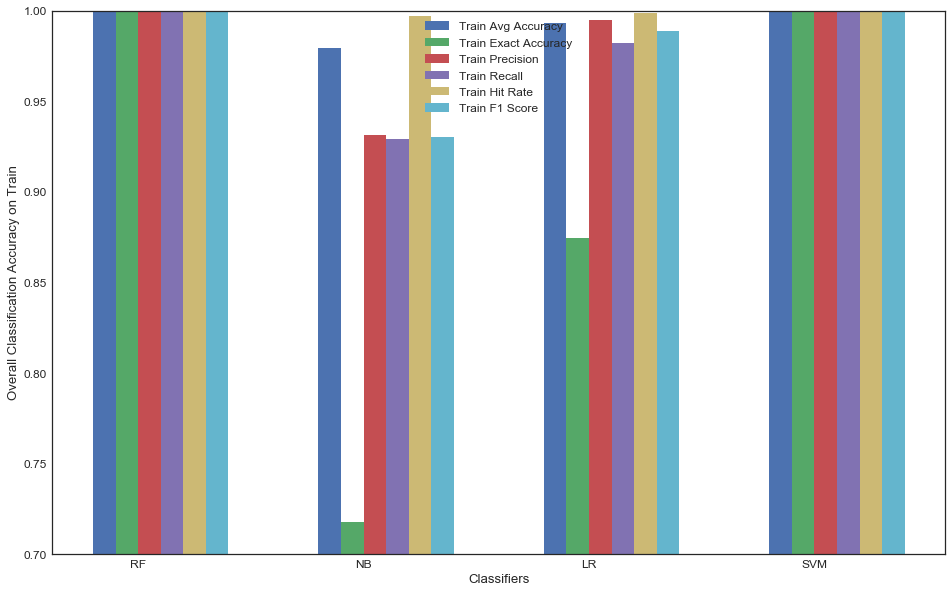

In [62]:
bar_width = 0.1
plt.figure(figsize = (16,10))
for i,idx in enumerate(score_df.index[:6]):
    plt.bar(np.arange(len(names_sorted))+i*bar_width, score_df[names_sorted].loc[idx], 
            bar_width, color=sns.color_palette()[i], label=idx)
plt.xticks(np.arange(len(names_sorted))+0.15, names_ticks)
plt.ylabel('Overall Classification Accuracy on Train')
plt.xlabel('Classifiers')
plt.legend(loc='best')
plt.ylim(0.7,1.0)
plt.show()


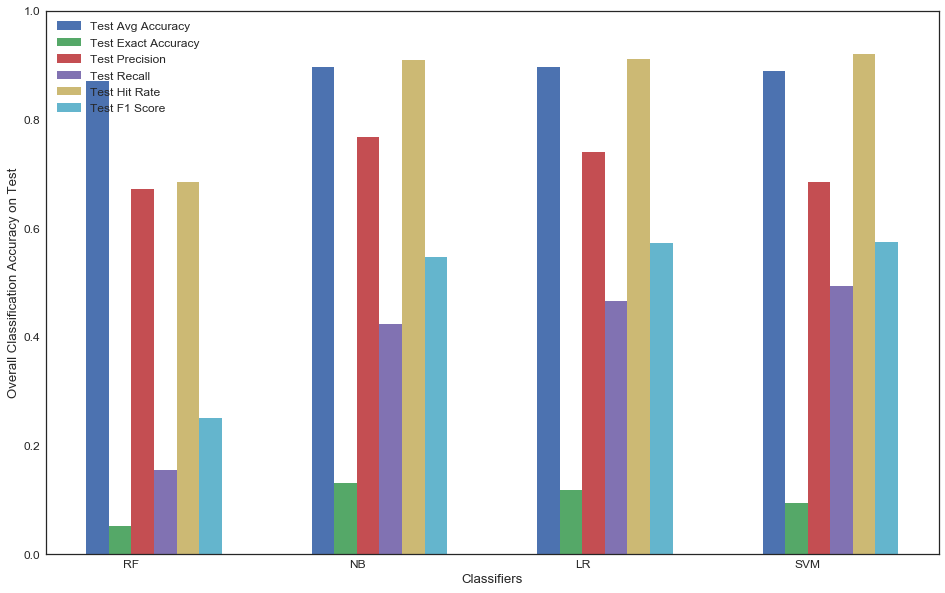

In [60]:
bar_width = 0.1
plt.figure(figsize = (16,10))
for i,idx in enumerate(score_df.index[6:12]):
    plt.bar(np.arange(len(names_sorted))+i*bar_width, score_df[names_sorted].loc[idx], 
            bar_width, color=sns.color_palette()[i], label=idx)
plt.xticks(np.arange(len(names_sorted))+0.15, names_ticks)
plt.ylabel('Overall Classification Accuracy on Test')
plt.xlabel('Classifiers')
plt.legend(loc='best')
plt.ylim(0,1)
plt.show()